Dataset link: https://tianchi.aliyun.com/dataset/dataDetail?dataId=46

- user_id
- item_id
- behavior_type
- user_geohash
- item_category
- time

## Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data overview

In [0]:
data_user = pd.read_csv('train_user.csv')

In [3]:
data_user.shape

(362534, 6)

In [4]:
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [5]:
data_user.dtypes

user_id           int64
item_id           int64
behavior_type     int64
user_geohash     object
item_category     int64
time             object
dtype: object

In [0]:
# missing value
missingTotal = data_user.isnull().sum()
missingExist = missingTotal[missingTotal > 0]
missingExist = missingExist.sort_values(ascending=False)

In [7]:
missingExist

user_geohash    245888
dtype: int64

We can see the column, user_geohash has null values.

Also we can see the time column need to be cleaned, bucause it contains date and the time both in one element.

In [8]:
data_user.loc[0, 'time']

'2014-12-06 02'

In [0]:
# separate date and time (hrs)
data_user['date'] = data_user['time'].map(lambda s: s.split(' ')[0])
data_user['hour'] = data_user['time'].map(lambda s: s.split(' ')[1])

In [10]:
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [0]:
# method II: using re when complex split pattern
# data_user['time'].map(lambda s: re.compile(' ').split(s)[0])

Then, we should convert the date and time into date type, currently they are both string.

In [12]:
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['time'] = pd.to_datetime(data_user['time'])
data_user['hour'] = data_user['hour'].astype('int64')
data_user.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
user_geohash             object
item_category             int64
time             datetime64[ns]
date             datetime64[ns]
hour                      int64
dtype: object

In [13]:
data_user.loc[0, 'time']

Timestamp('2014-12-06 02:00:00')

In [14]:
# see if there are some outliers
data_user = data_user.sort_values(by='time', ascending=True)
data_user = data_user.reset_index(drop=True)
data_user.describe()

,user_id,item_id,behavior_type,item_category,hour
count,3.625340e+05,3.625340e+05,362534.000000,362534.000000,362534.000000
mean,7.265333e+07,2.021039e+08,1.107430,6826.836382,14.771740
std,4.171993e+07,1.169389e+08,0.462168,3802.933299,6.530478
min,6.118000e+03,6.680000e+02,1.000000,8.000000,0.000000
25%,3.647133e+07,1.008812e+08,1.000000,3673.000000,10.000000
50%,7.342430e+07,2.017482e+08,1.000000,6209.000000,16.000000
75%,1.100435e+08,3.035041e+08,1.000000,10258.000000,20.000000
max,1.424302e+08,4.045613e+08,4.000000,14080.000000,23.000000


We can see all column contain common data, no weird record.

## Data exploration

### Page view (PV) and unique visitor (UV) - daily

In [0]:
pv_daily = data_user.groupby('date')['user_id'] \
            .count().reset_index() \
            .rename(columns={'user_id': 'pv'})
            
uv_daily = data_user.groupby('date')['user_id'] \
            .apply(lambda x:x.drop_duplicates().count()) \
            .reset_index() \
            .rename(columns={'user_id': 'uv'})

Text(0.5, 1.0, 'Daily unique user')

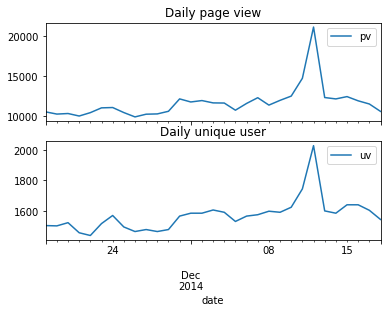

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_daily.plot(x='date', y='pv', ax=axes[0])
uv_daily.plot(x='date', y='uv', ax=axes[1])
axes[0].set_title('Daily page view')
axes[1].set_title('Daily unique user')

In [18]:
data_user['user_id'].nunique()

2975

The page view goes to peak on 12 Dec, which is a famous shopping holiday in China, similar to Boxing day and Black Friday.

Also, we can see there is a big discrepancy between total page view and number of unique users, that means the user active percentage is nearly 2000/2975 = 67% on 12 Dec.

### Page view (PV) and unique visitor (UV) - hourly

In [0]:
pv_hour = data_user.groupby('hour')['user_id'] \
            .count().reset_index() \
            .rename(columns={'user_id': 'pv_hour'})
            
uv_hour = data_user.groupby('hour')['user_id'] \
            .apply(lambda x:x.drop_duplicates().count()) \
            .reset_index() \
            .rename(columns={'user_id': 'uv_hour'})

Text(0.5, 1.0, 'Hourly unique user')

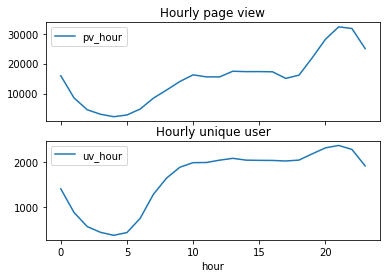

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_hour.plot(x='hour', y='pv_hour', ax=axes[0])
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1])
axes[0].set_title('Hourly page view')
axes[1].set_title('Hourly unique user')

Activity decrease sharply from 0 am to 5 am, and then bounce back to a very high activity at 10 am, consistently raise from 18 pm and then goes to highest in 21 pm. In short, users are most active starting from 18 pm.

### PV analysis for different behavior types

Text(0.5, 1.0, 'PV other different behavior types')

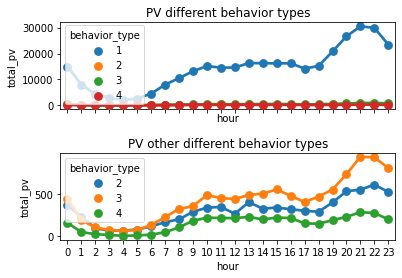

In [21]:
pv_detail = data_user.groupby(['hour', 'behavior_type'])['user_id'] \
              .count().reset_index().rename(columns={'user_id':'total_pv'})
              
fig, axes = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.5)
sns.pointplot(x='hour', y='total_pv', hue='behavior_type', data=pv_detail, ax=axes[0])
sns.pointplot(x='hour', y='total_pv', hue='behavior_type', data=pv_detail[pv_detail.behavior_type!=1], ax=axes[1])
axes[0].set_title('PV different behavior types')
axes[1].set_title('PV other different behavior types')

Click, collect, add-to-cart and payment, the corresponding values are 1, 2, 3 and 4,respectively. We can see clicking are the most active operation, and adding to cart is more active than collect.

### User buying times behavior

Text(0.5, 1.0, 'Daily user buy')

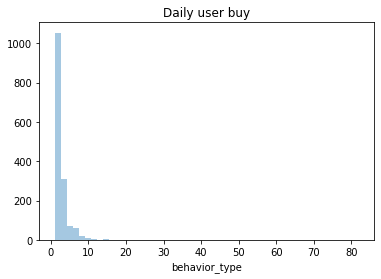

In [22]:
data_user_buy = data_user[data_user.behavior_type==4].groupby('user_id')['behavior_type'].count()
sns.distplot(data_user_buy, kde=False)
plt.title('Daily user buy')

We can see almost users pay no more than 10 times. Therefore, users who buy more than 10 times are more valuable or at least need more attention.

ARPPU (Average revenue per paying user), because we do not have revenue, replace the revenue with daily total paying times.

Text(0.5, 1.0, 'Daily ARPPU')

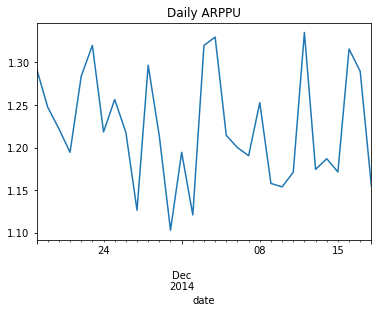

In [23]:
# how many paying times in total for each user daily
user_buy_daily = data_user[data_user.behavior_type==4].groupby(['date','user_id'])['behavior_type'] \
                  .count().reset_index().rename(columns={'behavior_type':'total'})

# compute the average per user daily
user_buy_daily.groupby('date').apply(lambda x:x.total.sum()/x.total.count()).plot()
plt.title('Daily ARPPU')

ARPU (Average revenue per user), here again replace revenue with paying times.

Text(0.5, 1.0, 'Daily ARPU')

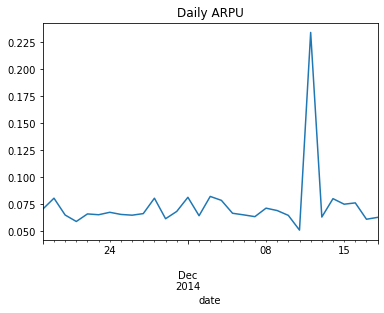

In [25]:
# because we will use three cols for grouping, add one more col to hold the results
data_user['operation'] = 1
data_user_buy2 = data_user.groupby(['date','user_id','behavior_type'])['operation'] \
                  .count().reset_index().rename(columns={'operation':'total'})
                  
# for each selected date, there is a dataframe(x) to do apply below
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type==4].total.sum()/x.user_id.nunique()).plot()
plt.title('Daily ARPU')

The difference between ARPPU and ARPU is that people are not the same group, the front one is paying users, the latter one is all active users who do any operations (whether paying or not).

Daily afford rate = how many users paid/active users.

Note: count() and sum() are different in this case because one user can operate/pay multiple times daily. So sum() is far much more than count().

Text(0.5, 1.0, 'Daily afford rate')

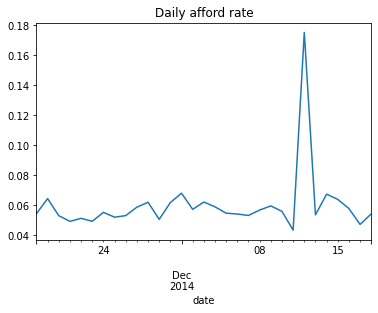

In [28]:
# here we care about number of paying users (count), not paying times (sum)
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type==4].total.count()/x.user_id.nunique()).plot()
plt.title('Daily afford rate')

How many times people buy in different time interval

Most users pay 1 times


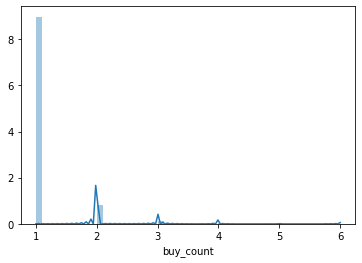

In [32]:
data_user_buy3 = data_user[data_user.behavior_type==4].groupby(['user_id','date','hour'])['operation'].sum().rename('buy_count')

sns.distplot(data_user_buy3)
print('Most users pay {} times'.format(data_user_buy3.mode()[0]))

### Rebuying behavior analysis

Rebuying user refers to users who buy more than two days.

In [46]:
# the date must be count by distinct because the buying behaviors in one day is considered once
# rename here change the series name, not column name
date_rebuy = data_user[data_user.behavior_type==4].groupby('user_id')['date'] \
              .apply(lambda x: x.nunique()).reset_index().rename(columns={'date':'rebuy_count'})

rate = len(date_rebuy[date_rebuy.rebuy_count>=2])/len(date_rebuy)
print('Rebuying rate is {}'.format(round(rate, 4)))

Rebuying rate is 0.4701


When people rebuy wrt time gap

Text(0, 0.5, 'How many people rebuy in this gap')

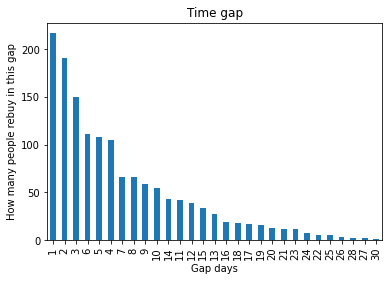

In [49]:
data_day_buy = data_user[data_user.behavior_type==4].groupby(['user_id','date'])['operation'].count().reset_index()
# diff(1) will compute the two elements difference, but the first element will be nan, dropna() to delete that row
data_user_buy4 = data_day_buy.groupby('user_id')['date'].apply(lambda x: x.sort_values().diff(1).dropna())
# extract day number from '12 days'
data_user_buy4 = data_user_buy4.map(lambda x: x.days)
data_user_buy4.value_counts().plot(kind='bar')
plt.title('Time gap')
plt.xlabel('Gap days')
plt.ylabel('How many people rebuy in this gap')

We can see the paying behavior is decreasing with the time gap between the first buying date. Need to pay attention to encourage users to rebuy within 10 days.

### User missing analysis

In [0]:
# len(df) is faster than df.shape[0] is faster than df.count()
pv_all = len(data_user['user_id'])

# What portion of users operate 4 behaviors in duration
data_user_count = data_user.groupby('behavior_type')['operation'].count() \
                    .apply(lambda x: x/pv_all).reset_index().rename(columns={'operation':'operation portion'})

In [59]:
data_user_count.head()

,behavior_type,operation portion
0,1,0.941291
1,2,0.020122
2,3,0.028453
3,4,0.010134


Different item category analysis, we can see four behaviors below.

In [62]:
data_category = data_user.groupby(['item_category', 'behavior_type'])['operation'].count() \
                  .unstack(level=1).rename(columns={1:'click',2:'collect',3:'add-to-cart',4:'buy'}).fillna(0)
# unstack - pivot table using the index in the specified level
data_category.head()

behavior_type,click,collect,add-to-cart,buy
item_category,,,,
8,3.0,0.0,0.0,0.0
10,9.0,0.0,0.0,0.0
11,294.0,6.0,2.0,0.0
12,2.0,0.0,0.0,0.0
13,1.0,0.0,0.0,0.0
